Restarted base (Python 3.9.13)

In [1]:
#########################################################################################################
######################## Start with initial linear classifier (initial accuracy) ########################
#########################################################################################################
import joblib
from sklearn.metrics import precision_score, recall_score, f1_score
import json
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
import warnings
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from tabulate import tabulate
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from scipy import stats


#Import  Dataset 
df = pd.read_csv('gpu_specs_v6.csv', header= 0,encoding= 'utf-8')

########### Data Preprocessing ###########
# Load the GPU dataset from CSV
df = pd.read_csv('gpu_specs_v6.csv', header=0, encoding='utf-8')
print("Number of rows and columns before dropping columns:", df.shape)

df_filtered = df.interpolate()
print("Number of rows and columns after interpolation columns:", df_filtered.shape)

df_filtered = df_filtered.dropna()
print("Number of rows and columns after dropping rows with missing values:", df_filtered.shape)

####### Dataset Features Selection #######
# List of columns to eliminate
columns_to_eliminate = ['manufacturer', 'productName', 'igp', 'bus', 'memType', 'gpuChip', 'pixelShader', 'vertexShader']
duplicate_rows = df_filtered[df_filtered.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape)
df_filtered = df_filtered.drop_duplicates()
print("Number of rows and columns after dropping duplicate rows:", df_filtered.shape)

# Calculate the Z-scores for each data point
z_scores = stats.zscore(df_filtered['releaseYear'])

# Set a threshold for identifying outliers (e.g., Z-score > 3)
threshold = 3

# Identify and filter out outliers
df_filtered = df_filtered[abs(z_scores) <= threshold]
print("Number of outliers:", df_filtered.shape)

# Filter out rows with Z-scores above the threshold
print("Number of rows and columns after removing outliers:", df_filtered.shape)


def plot_stacked_bar(data, series_labels, category_labels=None,
                     show_values=False, value_format="{}", y_label=None,
                     colors=None, grid=False, reverse=False):

    ny = len(data[0])
    ind = list(range(ny))

    axes = []
    cum_size = np.zeros(ny)

    data = np.array(data)

    if reverse:
        data = np.flip(data, axis=1)
        category_labels = reversed(category_labels)

    for i, row_data in enumerate(data):
        color = colors[i] if colors is not None else None
        axes.append(plt.bar(ind, row_data, bottom=cum_size,
                            label=series_labels[i], color=color))
        cum_size += row_data

    if category_labels:
        plt.xticks(ind, category_labels)

    if y_label:
        plt.ylabel(y_label)

    plt.legend()

    if grid:
        plt.grid()

    if show_values:
        for axis in axes:
            for bar in axis:
                w, h = bar.get_width(), bar.get_height()
                plt.text(bar.get_x() + w/2, bar.get_y() + h/2,
                         value_format.format(h), ha="center",
                         va="center")


###### Dataset Hyperparameter optimization ########
main_df = df_filtered.loc[:,['releaseYear','tmu','gpuClock','memClock','memBusWidth']]
X = main_df.copy()

y =  X.pop('releaseYear')
#y =  X['releaseYear']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Apply PCA
# Choose the number of principal components
pca = PCA(n_components=min(X_train_scaled.shape[0], X_train_scaled.shape[1]))
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Feature selection using SelectKBest and ANOVA
# Choose the number of top features to select
selector = SelectKBest(score_func=f_classif, k=4)
X_train_selected = selector.fit_transform(X_train_pca, y_train)
X_test_selected = selector.transform(X_test_pca)

# Print selected features
selected_feature_indices = selector.get_support(indices=True)
selected_features = X.columns[selected_feature_indices]

# Define a list of classifiers
classifiers = [
    ('RFC', RandomForestClassifier(random_state=42), {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}),
    ('DTC', DecisionTreeClassifier(random_state=42), {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}), 
    ('SVM', SVC(random_state=42), {'C': [0.1, 1, 10],  'gamma': ['scale', 'auto']}),  # For SVM, gamma parameter
    ('KNN', KNeighborsClassifier(), {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}),
    ('LDA', LinearDiscriminantAnalysis(), {}),  # LDA has no hyperparameters in this example
    ('GNB', GaussianNB(), {})  # Gaussian Naive Bayes has no hyperparameters
]

names = []        
arr_Var = [] 
arr_Mean = [] 
arr_Iteration = []
arr_results=[]
results =[]

# Create a dictionary to store the trained models
trained_models = {}

average_type = 'weighted' 
results_arr_GS = []
results_arr_RS = []
results_arr_CV = []
i = 0
for i in range(1,100):
    print(i)
    arr_executionTime = []       
    arr_best_param = []
    for name, classifier, param_dist in classifiers:
        kfold = model_selection.StratifiedKFold(n_splits=10)
        cv_results = model_selection.cross_val_score(classifier, X_train, y_train,cv=kfold, scoring='accuracy')
        dT1 = time.time()
        classifier.fit(X_train, y_train)
        pred = classifier.predict(X_test)
        dT2 = time.time()
        trained_models[f'{name}_{i}'] = classifier
        arr_executionTime.append(dT2-dT1)
        names.append(name)
        #results.append(cv_results)
        arr_results.append(cv_results.mean())
        #arr_Var.append(np.var(arr_executionTime))
        arr_Mean.append(np.mean(arr_executionTime))
        arr_Iteration.append(i)
        #j=j+1
        report = classification_report(y_test, pred, output_dict=True)
        results.append((name, cv_results.mean(), report['accuracy'], report['weighted avg']['precision'],
                    report['weighted avg']['recall'], report['weighted avg']['f1-score'], dT2-dT1, i))

        # Perform cross-validation
        dT1 = time.time()

        scores = cross_val_score(
            classifier, X_train_selected, y_train, cv=10, scoring='accuracy')
        # Train the selected classifier on the whole training set
        classifier.fit(X_train_selected, y_train)

        trained_models[f'{name}_CV_{i}'] = classifier

        # Make predictions on the test set
        y_pred = classifier.predict(X_test_selected)
        dT2 = time.time()

        # Evaluate the classifier
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average=average_type)
        recall = recall_score(y_test, y_pred, average=average_type)
        f1 = f1_score(y_test, y_pred, average=average_type)

        # Append results to the DataFrame
        results_arr_CV.append({
            'Algorithm': name,
            'CV_Accuracy': scores.mean(),
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'Execution Time': dT2-dT1
            #'CV Accuracy Std': scores.std()
        })

        # Perform cross-validation with hyperparameter optimization
        dT1 = time.time()
        grid_search = GridSearchCV(
            classifier, param_dist, cv=10, scoring='accuracy', return_train_score=False)
        grid_search.fit(X_train_selected, y_train)
        r = grid_search.cv_results_

        for mean_score, std_score, params in zip(r['mean_test_score'], r['std_test_score'], r['params']):
            arr_best_param.append({'Classifier': name, 'Accuracy': mean_score,
                        'Std test score': std_score, 'params': params})

        trained_models[f'{name}_GS_{i}'] = grid_search

        # Get the best classifier with optimized hyperparameters
        best_classifier = grid_search.best_estimator_

        # Make predictions on the test set
        y_pred = best_classifier.predict(X_test_selected)
        dT2 = time.time()
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average=average_type)
        recall = recall_score(y_test, y_pred, average=average_type)
        f1 = f1_score(y_test, y_pred, average=average_type)

        # Append results to the DataFrame
        results_arr_GS.append({
            'Algorithm': name,
            'CV_Accuracy': grid_search.best_score_,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'Execution Time': dT2-dT1
            #'Best Parameters': grid_search.best_params_
        })
# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=[
                          'Algorithm', 'CV_Accuracy', 'Accuracy', 'Precision', 'Recall', 'F1', 'Execution Time', 'Iterations'])
results_crossValidation = results_df

print("Total Iterations = " + str(i))
#print("\nResults from Cross validation:")
results_CV_new = pd.DataFrame(results_arr_CV)

# Create a Pandas DataFrame from the results
results_GS = pd.DataFrame(results_arr_GS)

# Save the dictionary containing all the trained models
joblib.dump(trained_models, 'multiple_models.pkl')

Number of rows and columns before dropping columns: (2889, 15)
Number of rows and columns after interpolation columns: (2889, 15)
Number of rows and columns after dropping rows with missing values: (1835, 15)
Number of duplicate rows: (7, 15)
Number of rows and columns after dropping duplicate rows: (1828, 15)
Number of outliers: (1775, 15)
Number of rows and columns after removing outliers: (1775, 15)
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Total Iterations = 99


['multiple_models.pkl']

In [2]:
######### Plotting #########

# df_plt = pd.DataFrame({
#     "Algorithm": results_crossValidation['Algorithm'], 
#     "Iterations": results_crossValidation['Iterations'],   
#     "Accuracy": results_crossValidation['Accuracy'],
#     "Execution Time": results_crossValidation['Execution Time']
#  })

# columns_to_convert = ['Iterations', 'Accuracy', 'Execution Time']

# for column in columns_to_convert:
#     df_plt[column] = pd.to_numeric(df_plt[column])

######### Performance #########
# arr_algo = ['RFC', 'DTC', 'SVM', 'KNN', 'LDA', 'GNB']
# arr_accuracy=[]
# arr_precision =[]
# arr_recall=[]
# arr_f1=[]

# plt.figure(figsize=(5, 7))

# series_labels = ['Accuracy', 'Execution Time (Sec)']
# data = df_plt.groupby("Algorithm").mean()[['Accuracy', 'Execution Time']]

# data = [
#     data['Accuracy'],
#     data['Execution Time']
# ]
# category_labels = ['RFC', 'DTC', 'SVM', 'KNN', 'LDA', 'GNB']
# plot_stacked_bar(
#     data, 
#     series_labels, 
#     category_labels=category_labels, 
#     show_values=True, 
#     value_format="{:.2f}",
#     colors=['#29a8ab','#bbbbbb'],
#     y_label="Performance Cross-validation (Total iterations = " + str(i) + ")"
# )

# plt.savefig('bar.png')
# plt.legend(loc='upper right')
# plt.savefig('../Report/Plots/Performance_CV.png')
# plt.show()


#plt.figure(figsize=(8, 6))

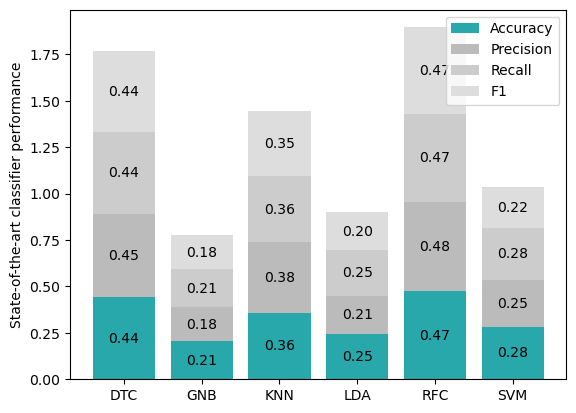

In [3]:
############ Performance before ############
series_labels = ['Accuracy', 'Precision', 'Recall', 'F1']
a_df = results_crossValidation.groupby("Algorithm").mean()[['Accuracy', 'Precision', 'Recall', 'F1']]
a_df = [a_df['Accuracy'], a_df['Precision'], a_df['Recall'], a_df['F1']]

plot_stacked_bar(
    a_df, 
    series_labels, 
    category_labels=list(a_df[0].keys()),
    show_values=True, 
    value_format="{:.2f}",
    colors=['#29a8ab','#bbbbbb','#cccccc', '#dddddd'],
    y_label="State-of-the-art classifier performance"
)

plt.legend(loc='upper right')
plt.savefig('../Report/Plots/Performance_before.png')
plt.show()

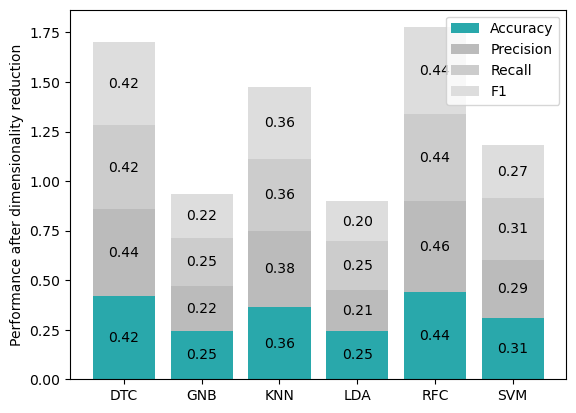

In [4]:
############ Performance after dimensionality reduction ############
series_labels = ['Accuracy', 'Precision', 'Recall', 'F1']
b_df = results_CV_new.groupby("Algorithm").mean()[['Accuracy', 'Precision', 'Recall', 'F1']]
b_df = [b_df['Accuracy'], b_df['Precision'], b_df['Recall'], b_df['F1']]

plot_stacked_bar(
    b_df, 
    series_labels, 
    category_labels=list(b_df[0].keys()),
    show_values=True, 
    value_format="{:.2f}",
    colors=['#29a8ab','#bbbbbb','#cccccc', '#dddddd'],
    y_label="Performance after dimensionality reduction"
)

plt.legend(loc='upper right')
plt.savefig('../Report/Plots/Performance_after_dimensionality_reduction.png')
plt.show()

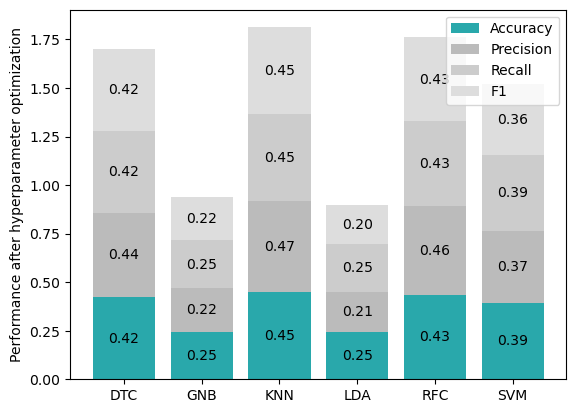

In [5]:
############ Performance after dimensionality reduction and HP optimization ############
series_labels = ['Accuracy', 'Precision', 'Recall', 'F1']
c_df = results_GS.groupby("Algorithm").mean()[['Accuracy', 'Precision', 'Recall', 'F1']]
c_df = [c_df['Accuracy'], c_df['Precision'], c_df['Recall'], c_df['F1']]

plot_stacked_bar(
    c_df,
    series_labels,
    category_labels=list(c_df[0].keys()),
    show_values=True,
    value_format="{:.2f}",
    colors=['#29a8ab', '#bbbbbb', '#cccccc', '#dddddd'],
    y_label="Performance after hyperparameter optimization"
)

plt.legend(loc='upper right')
plt.savefig('../Report/Plots/Performance_after_dimensionality_reduction_and_HP_optimization.png')
plt.show()

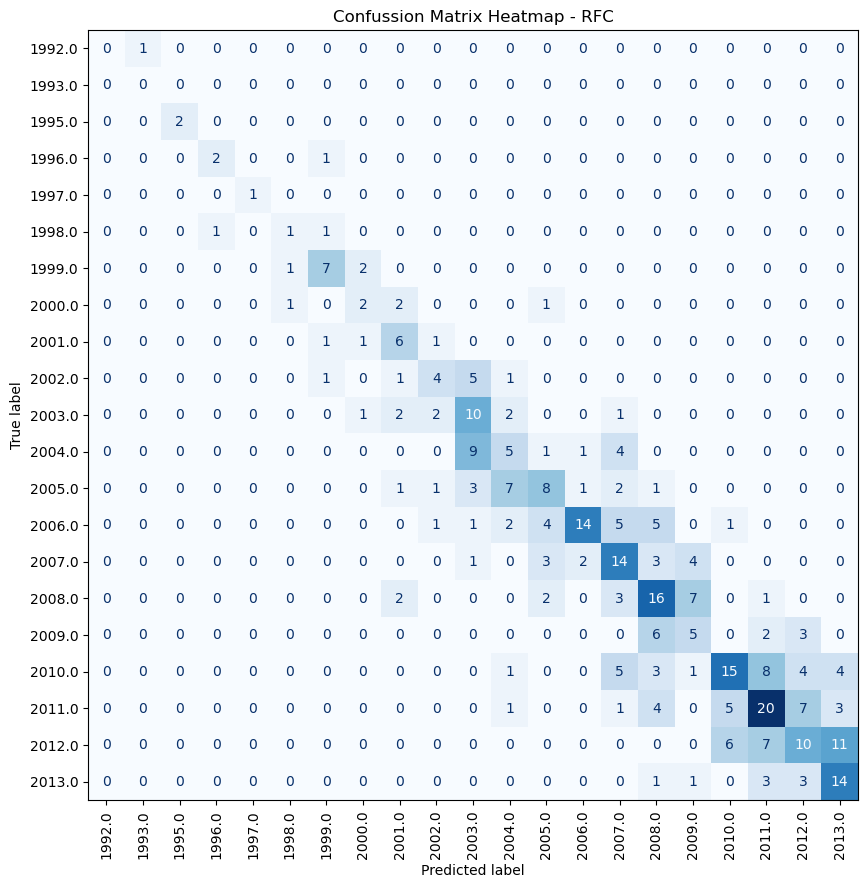

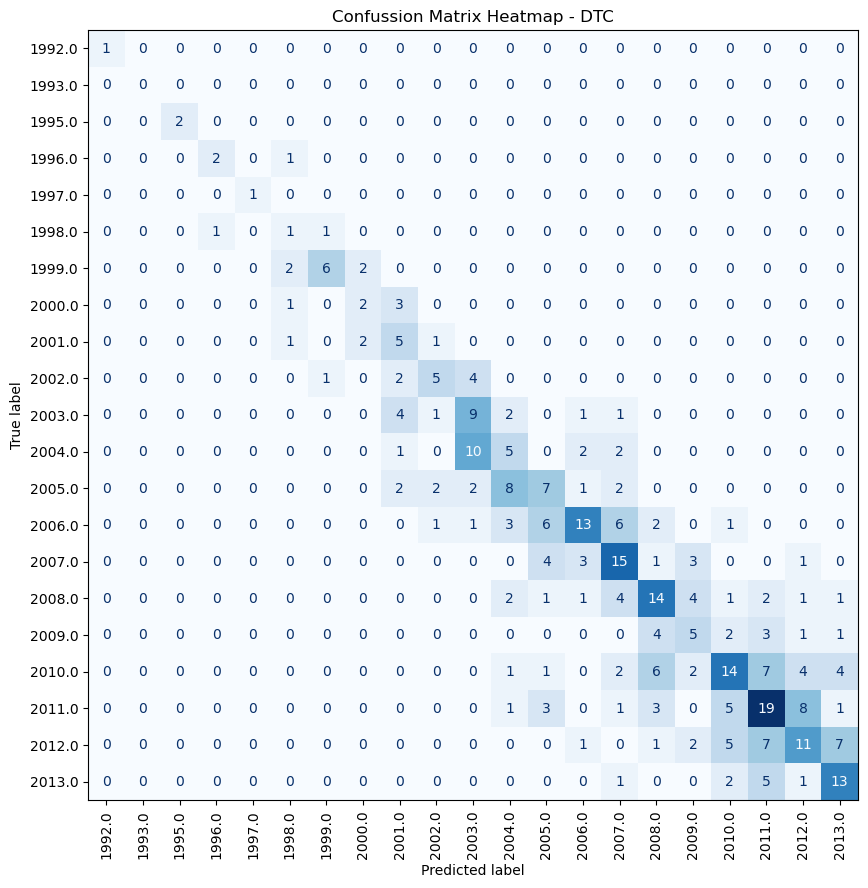

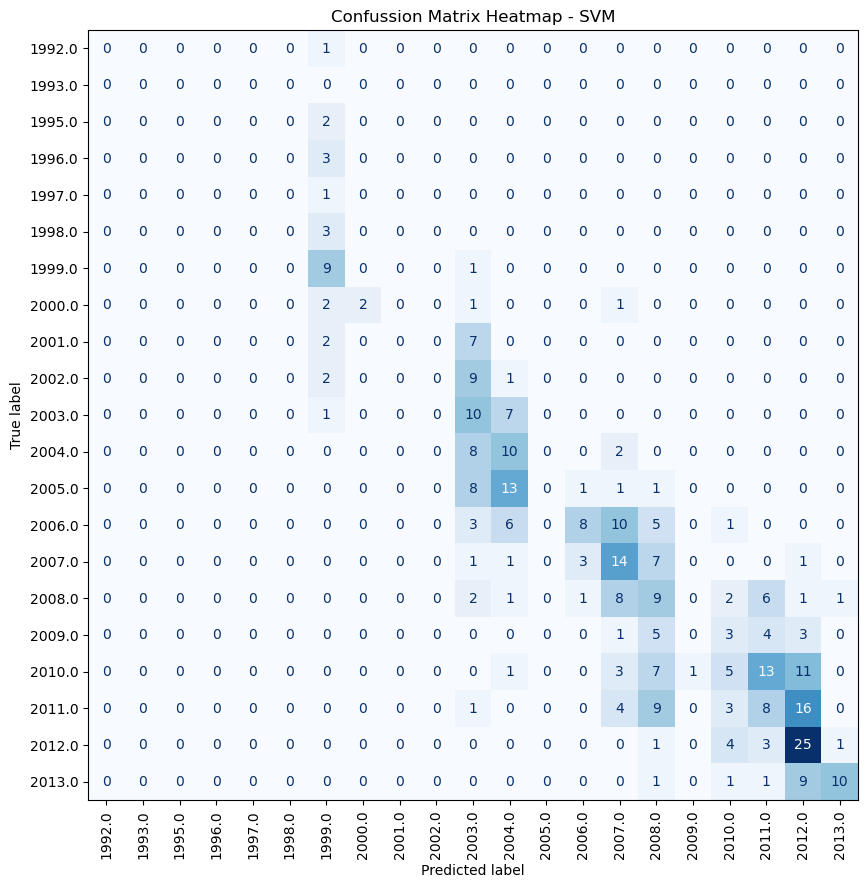

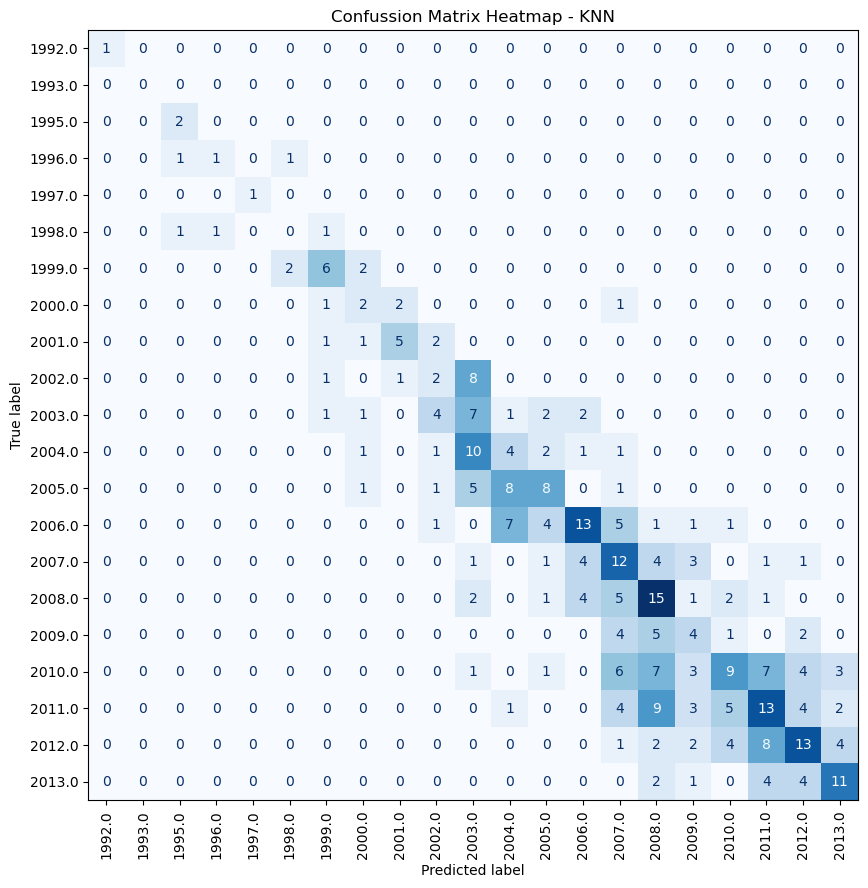

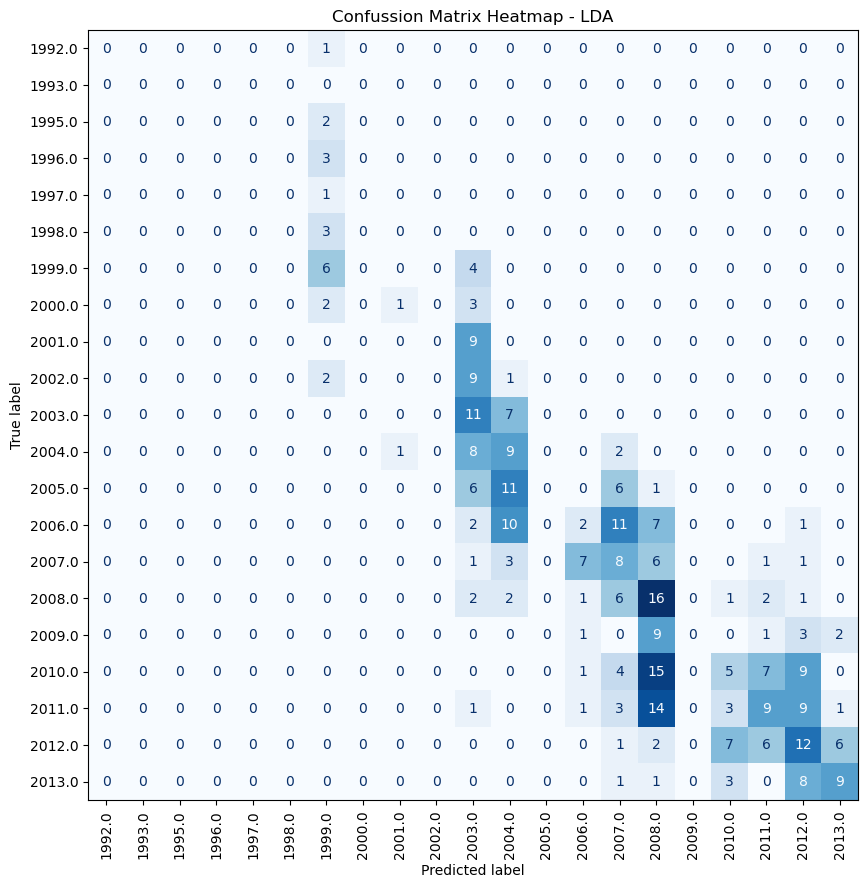

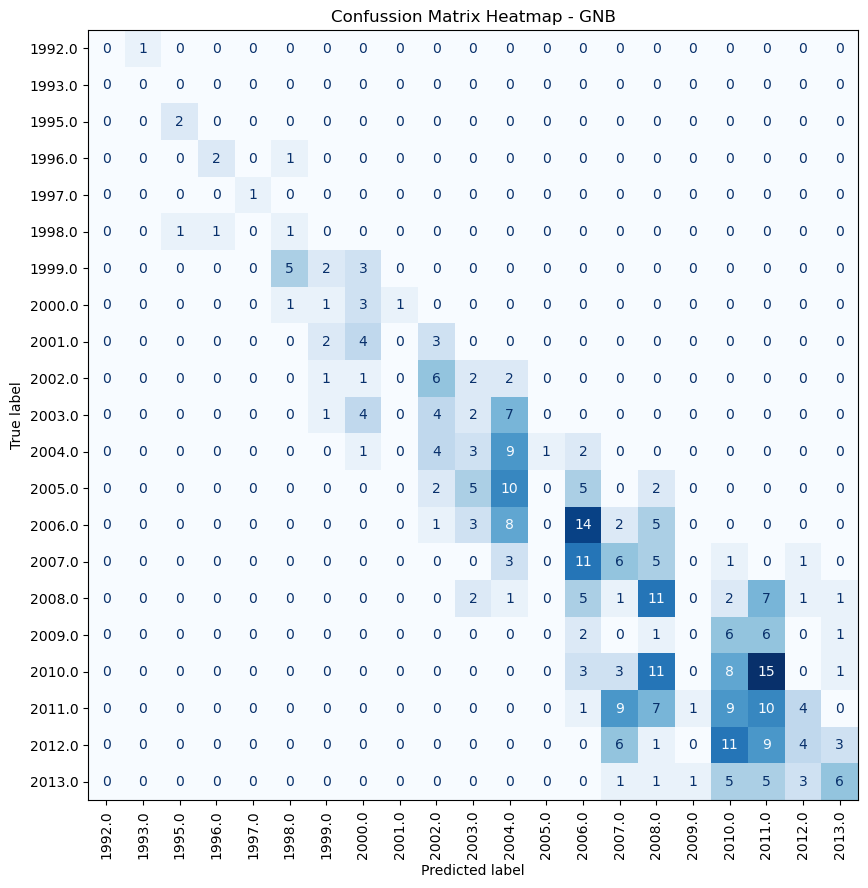

In [6]:
###### Confusion Matrix after optimization ######
for name, model, param_dist in classifiers:
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_title('Confussion Matrix Heatmap - ' + name)

    if isinstance(model, (GridSearchCV)):
        best_estimator = model.best_estimator_
        ConfusionMatrixDisplay.from_predictions(y_test, best_classifier.predict(X_test_selected), labels=model.classes_, xticks_rotation="vertical", cmap="Blues",
                            display_labels=model.classes_, ax=ax, colorbar=False)
    else:
        ConfusionMatrixDisplay.from_predictions(y_test, model.predict(X_test_selected), labels=model.classes_, xticks_rotation="vertical", cmap="Blues",
                                    display_labels=model.classes_, ax=ax, colorbar=False)
    plt.savefig('../Report/Plots/CM_Heatmap_' + name + '.png')

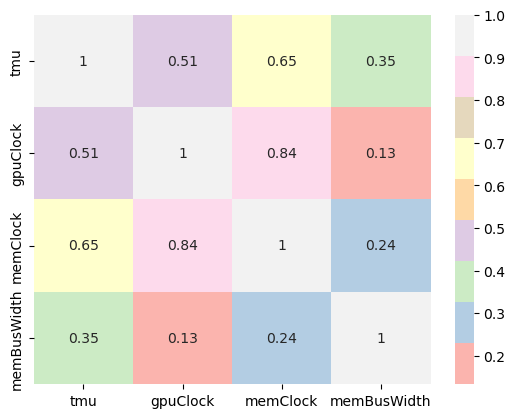

In [7]:
###### Heatmap ######
corr = X.corr(method='pearson')
sns.heatmap(corr, cmap="Pastel1", annot=True)
plt.savefig('../Report/Plots/DataCorelation.png')

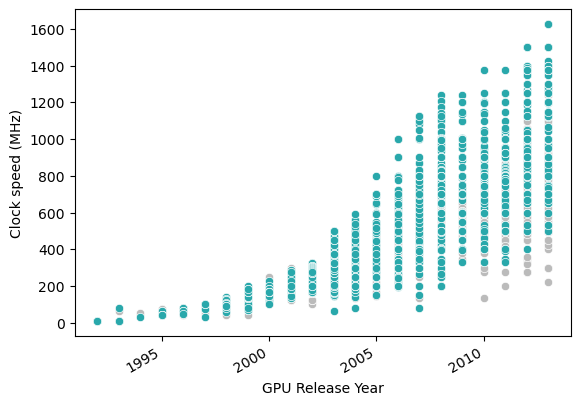

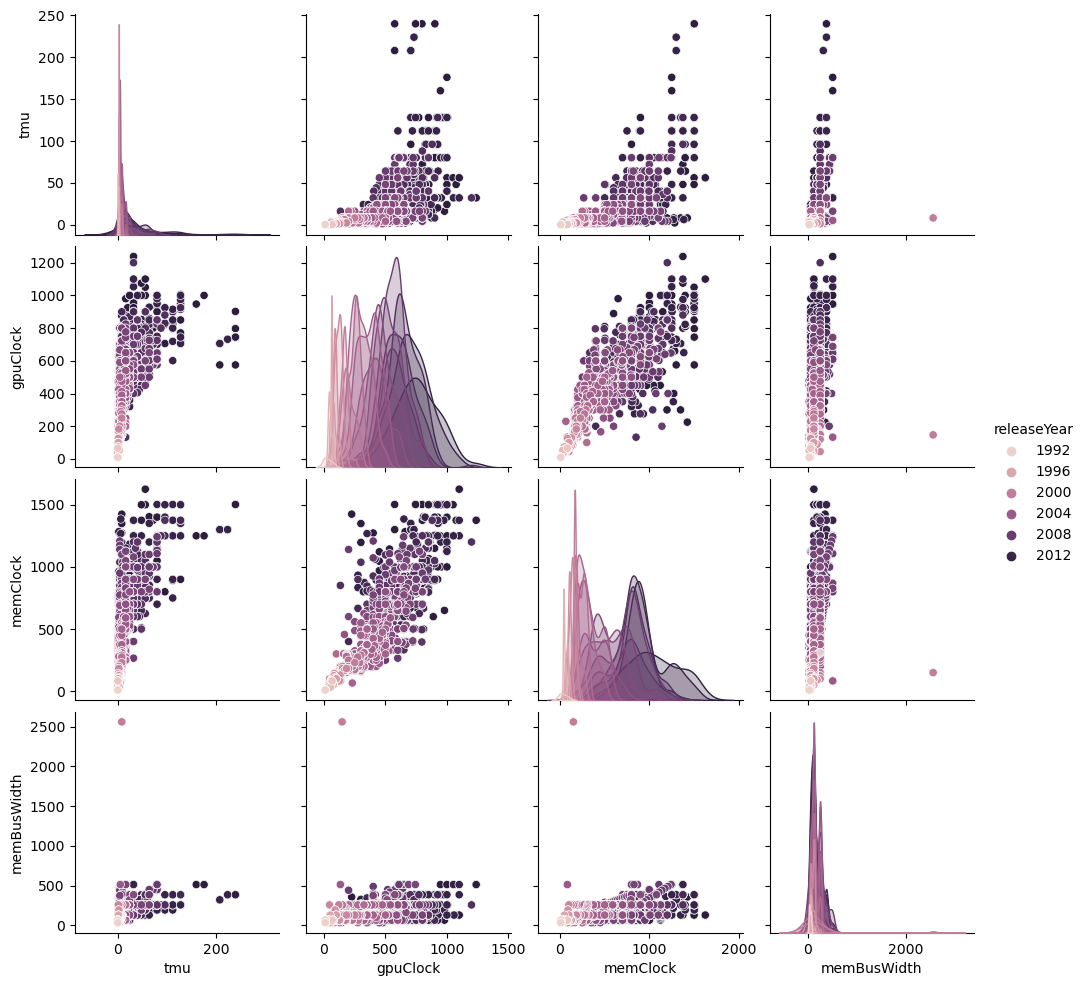

In [8]:
###### Data ######
# ###### Bar Plot ######
# plt.title('GPU Memory Type')
# X['releaseYear'].value_counts().plot.bar(color=['#bbbbbb','#66CDAA','#008B8B'])
# fig = plt.figure(figsize =(8, 8))
# plt.show()
# plt.savefig('../Report/Plots/DataBarplot.png')


###### Scatter Plot ######
gCmC = sns.scatterplot(x="releaseYear", y="gpuClock", ci=None, data=main_df,color = '#bbbbbb')
gCmC = sns.scatterplot(x="releaseYear", y="memClock", ci=None, data=main_df, color='#29a8ab')
gCmC.figure.autofmt_xdate()
plt.xlabel('GPU Release Year')
# Set y-axis label
plt.ylabel('Clock speed (MHz)')
plt.savefig('../Report/Plots/DatagpuClockvsmemClock.png')


##### Pairplot (Hue) #####
y = sns.pairplot(main_df, hue='releaseYear')
plt.savefig('../Report/Plots/DataPariPlot.png')


########## Box Plot ##########
#del results_crossValidation['Iterations']

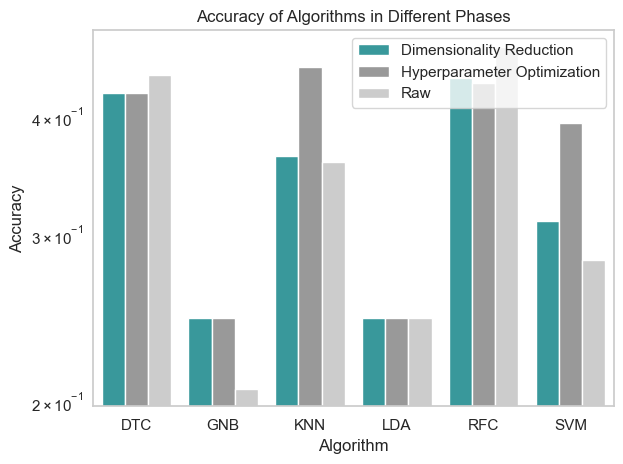

In [9]:
r1 = results_crossValidation.groupby('Algorithm').mean().reset_index(
).applymap(lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x)
r2 = results_CV_new.groupby('Algorithm').mean().reset_index().applymap(
    lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x)
r3 = results_GS.groupby('Algorithm').mean().reset_index().applymap(
    lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x)
r2["Phase"] = "Dimensionality Reduction"
r3["Phase"] = "Hp Optimization"
r1["Phase"] = "Raw"

combined_df = pd.concat(
    [r1,
     r2, r3])

columns = [
    "Algorithm", "Accuracy", "Phase", "Execution Time"]

df = pd.DataFrame(combined_df, columns=columns)
#print(data)
# Pivot the dataframe to the desired format
pivot_df = df.pivot_table(
    index="Algorithm",
    columns="Phase",
    values="Accuracy",
    aggfunc="first"
).reset_index()

# Rename the columns
pivot_df.columns.name = None
pivot_df = pivot_df.rename(columns={
    "Raw": "Raw",
    "Dimensionality Reduction": "Dimensionality Reduction",
    "Hp Optimization": "Hyperparameter Optimization"
})

# Melt the DataFrame to reorganize the execution time values
melted_df = pd.melt(pivot_df, id_vars=[
                    "Algorithm"], var_name="Phase", value_name="Accuracy")
melted_df["Accuracy"] = pd.to_numeric(melted_df["Accuracy"])

#plt.figure(figsize=(6, 5))

# Set the style of the plots
sns.set(style="whitegrid")
custom_palette = ["#29a8ab", "#999999", "#cccccc"]


# Create a bar plot for execution time of each algorithm in different phases
sns.barplot(data=melted_df, x="Algorithm", y="Accuracy",
            hue="Phase", palette=custom_palette)
plt.title("Accuracy of Algorithms in Different Phases")
plt.ylabel("Accuracy")
# Using a logarithmic scale for better visualization of large values
plt.yscale("log")
plt.legend(loc='upper right')
plt.tight_layout()

# Show the plot
plt.show()

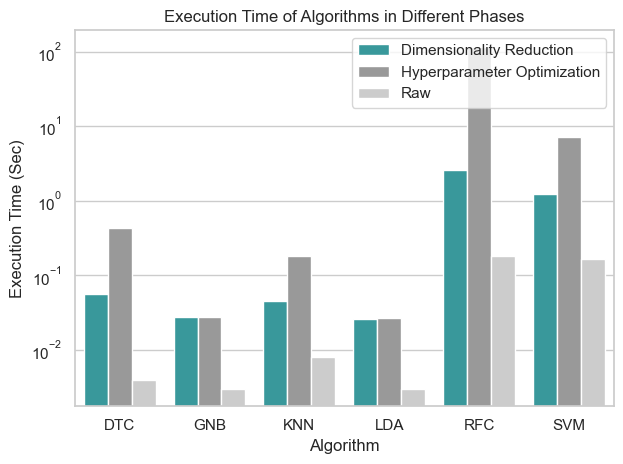

In [10]:
pivot_df = df.pivot_table(
    index="Algorithm",
    columns="Phase",
    values="Execution Time",
    aggfunc="first"
).reset_index()

# Rename the columns
pivot_df.columns.name = None
pivot_df = pivot_df.rename(columns={
    "Raw": "Raw",
    "Dimensionality Reduction": "Dimensionality Reduction",
    "Hp Optimization": "Hyperparameter Optimization"
})


# Melt the DataFrame to reorganize the execution time values
melted_df = pd.melt(pivot_df, id_vars=[
                    "Algorithm"], var_name="Phase", value_name="Execution Time")
melted_df["Execution Time"] = pd.to_numeric(melted_df["Execution Time"])
# Set the style of the plots
sns.set(style="whitegrid")

# Create a figure with subplots
#plt.figure(figsize=(10, 6))

# Create a bar plot for execution time of each algorithm in different phases
sns.barplot(data=melted_df, x="Algorithm", y="Execution Time",
            hue="Phase", palette=custom_palette)
plt.title("Execution Time of Algorithms in Different Phases")
plt.ylabel("Execution Time (Sec)")
# Using a logarithmic scale for better visualization of large values
plt.yscale("log")
plt.xticks()  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.legend(loc='upper right')
# Show the plot
plt.show()

In [11]:
########################## Print all results ##########################
# Print Selected Features
print("Selected Features:")
print(selected_features)

# Print Explained Variance Ratio of PCA Components
print("\nExplained Variance Ratio of PCA Components:")
print(np.around(pca.explained_variance_ratio_, decimals=3))

explained_variance_ratio_rounded = np.around(
    pca.explained_variance_ratio_, decimals=3)

# Convert the rounded array to a list of lists
data = [['Explained Variance Ratio', *explained_variance_ratio_rounded]]

# Print the rounded array using tabulate in LaTeX format
latex_table = tabulate(data, headers='firstrow', tablefmt='pretty')
print(latex_table)  
# Print Cross-validation and Performance Results
print("Cross-validation and Performance Results:\n")
print(tabulate(results_crossValidation.groupby('Algorithm').mean().reset_index().applymap(lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x), headers='keys', tablefmt='pretty', showindex=False))


# Print Results: Cross-validation
print("\nResults Cross-validation:")
print(tabulate(results_CV_new.groupby('Algorithm').mean().reset_index().applymap(lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x), headers='keys', tablefmt='pretty', showindex=False))

# Print Results: Grid Search CV
print("\nResults Grid Search CV:")
print(tabulate(results_GS.groupby('Algorithm').mean().reset_index().applymap(lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x), headers='keys', tablefmt='pretty', showindex=False))

Selected Features:
Index(['tmu', 'gpuClock', 'memClock', 'memBusWidth'], dtype='object')

Explained Variance Ratio of PCA Components:
[0.625 0.233 0.109 0.032]
+--------------------------+-------+-------+-------+-------+
| Explained Variance Ratio | 0.625 | 0.233 | 0.109 | 0.032 |
+--------------------------+-------+-------+-------+-------+
+--------------------------+-------+-------+-------+-------+
Cross-validation and Performance Results:

+-----------+-------------+----------+-----------+--------+-------+----------------+------------+
| Algorithm | CV_Accuracy | Accuracy | Precision | Recall |  F1   | Execution Time | Iterations |
+-----------+-------------+----------+-----------+--------+-------+----------------+------------+
|    DTC    |    0.401    |  0.442   |   0.449   | 0.442  | 0.436 |     0.004      |   50.000   |
|    GNB    |    0.229    |  0.206   |   0.182   | 0.206  | 0.183 |     0.003      |   50.000   |
|    KNN    |    0.361    |  0.358   |   0.379   | 0.358  | 0.3

In [12]:
# Print best parameters
print(tabulate(pd.DataFrame(arr_best_param), headers='keys', tablefmt='pretty', showindex=False))

+------------+---------------------+----------------------+-------------------------------------------------------------------+
| Classifier |      Accuracy       |    Std test score    |                              params                               |
+------------+---------------------+----------------------+-------------------------------------------------------------------+
|    RFC     |  0.421830985915493  | 0.02345186733147425  | {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}  |
|    RFC     | 0.4147887323943662  | 0.02567285370923688  | {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}  |
|    RFC     | 0.4154929577464789  | 0.027635798408941665 | {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}  |
|    RFC     | 0.4140845070422535  | 0.026312030552492118 | {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}  |
|    RFC     | 0.4119718309859155  | 0.02639671100562156  | {'max_depth': None, 'min_samples_split': 5, 

In [13]:
print("Selected Features:")
print(selected_features)

# Print Explained Variance Ratio of PCA Components
print("\nExplained Variance Ratio of PCA Components:")
print(np.around(pca.explained_variance_ratio_, decimals=3))

# Print Cross-validation and Performance Results
print("Cross-validation and Performance Results:\n")
print(tabulate(results_crossValidation, headers='keys', tablefmt='latex', showindex=False))


# Print Results: Cross-validation
print("\nResults Cross-validation:")
print(tabulate(results_arr_CV, headers='keys', tablefmt='latex', showindex=False))

# Print Results: Grid Search CV
print("\nResults Grid Search CV:")
print(tabulate(results_arr_GS, headers='keys', tablefmt='latex', showindex=False))

Selected Features:
Index(['tmu', 'gpuClock', 'memClock', 'memBusWidth'], dtype='object')

Explained Variance Ratio of PCA Components:
[0.625 0.233 0.109 0.032]
Cross-validation and Performance Results:

\begin{tabular}{lrrrrrrr}
\hline
 Algorithm   &   CV\_Accuracy &   Accuracy &   Precision &   Recall &       F1 &   Execution Time &   Iterations \\
\hline
 RFC         &      0.440845 &   0.473239 &    0.482281 & 0.473239 & 0.467693 &       0.174307   &            1 \\
 DTC         &      0.400704 &   0.442254 &    0.449104 & 0.442254 & 0.435644 &       0.00341797 &            1 \\
 SVM         &      0.280986 &   0.28169  &    0.253084 & 0.28169  & 0.219221 &       0.16543    &            1 \\
 KNN         &      0.360563 &   0.357746 &    0.379279 & 0.357746 & 0.351769 &       0.00790095 &            1 \\
 LDA         &      0.261972 &   0.24507  &    0.205744 & 0.24507  & 0.202823 &       0.00262189 &            1 \\
 GNB         &      0.228873 &   0.205634 &    0.182054 & 0.205634

In [14]:
#print(tabulate(my_array, tablefmt="grid"))
print(tabulate(results_crossValidation.drop(columns='Iterations'),
      headers='keys', tablefmt="latex", showindex=False))
print(tabulate(results_CV_new, headers='keys', tablefmt="latex", showindex=False))
print(tabulate(results_GS, headers='keys', tablefmt="latex", showindex=False))

\begin{tabular}{lrrrrrr}
\hline
 Algorithm   &   CV\_Accuracy &   Accuracy &   Precision &   Recall &       F1 &   Execution Time \\
\hline
 RFC         &      0.440845 &   0.473239 &    0.482281 & 0.473239 & 0.467693 &       0.174307   \\
 DTC         &      0.400704 &   0.442254 &    0.449104 & 0.442254 & 0.435644 &       0.00341797 \\
 SVM         &      0.280986 &   0.28169  &    0.253084 & 0.28169  & 0.219221 &       0.16543    \\
 KNN         &      0.360563 &   0.357746 &    0.379279 & 0.357746 & 0.351769 &       0.00790095 \\
 LDA         &      0.261972 &   0.24507  &    0.205744 & 0.24507  & 0.202823 &       0.00262189 \\
 GNB         &      0.228873 &   0.205634 &    0.182054 & 0.205634 & 0.18264  &       0.002671   \\
 RFC         &      0.440845 &   0.473239 &    0.482281 & 0.473239 & 0.467693 &       0.176626   \\
 DTC         &      0.400704 &   0.442254 &    0.449104 & 0.442254 & 0.435644 &       0.00340414 \\
 SVM         &      0.280986 &   0.28169  &    0.253084 & 0.

In [15]:
print(tabulate(pd.DataFrame(arr_best_param), headers='keys', tablefmt='latex', showindex=False))

\begin{tabular}{lrrl}
\hline
 Classifier   &   Accuracy &   Std test score & params                                                            \\
\hline
 RFC          &   0.421831 &        0.0234519 & \{'max\_depth': None, 'min\_samples\_split': 2, 'n\_estimators': 100\}  \\
 RFC          &   0.414789 &        0.0256729 & \{'max\_depth': None, 'min\_samples\_split': 2, 'n\_estimators': 200\}  \\
 RFC          &   0.415493 &        0.0276358 & \{'max\_depth': None, 'min\_samples\_split': 2, 'n\_estimators': 300\}  \\
 RFC          &   0.414085 &        0.026312  & \{'max\_depth': None, 'min\_samples\_split': 5, 'n\_estimators': 100\}  \\
 RFC          &   0.411972 &        0.0263967 & \{'max\_depth': None, 'min\_samples\_split': 5, 'n\_estimators': 200\}  \\
 RFC          &   0.409155 &        0.0271743 & \{'max\_depth': None, 'min\_samples\_split': 5, 'n\_estimators': 300\}  \\
 RFC          &   0.41338  &        0.0175492 & \{'max\_depth': None, 'min\_samples\_split': 10, 'n\_estimato

In [16]:
import joblib
import re
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Load the dictionary containing the search results
loaded_search_results = joblib.load('multiple_models.pkl')

pattern1 = r'^.{3}_\d+$'        # The regex pattern to match any three characters followed by an underscore and one or more digits
pattern2 = r'^.{3}_CV_\d+$'     # The regex pattern to match any three characters followed by an underscore and one or more digits
pattern3 = r'^.{3}_GS_\d+$'     # The regex pattern to match any three characters followed by an underscore and one or more digits

# Loop through the loaded search results
for key, loaded_search_obj in loaded_search_results.items():
    # Parse the key to extract the components (name, i, n)
    if re.match(pattern1, key):
        components = key.split('_')
        name, i = components[0], components[1]
    elif re.match(pattern2, key):
        components = key.split('_CV_')
        name, i = components[0], components[1]
    elif re.match(pattern3, key):
        components = key.split('_GS_')
        name, i = components[0], components[1]
    else:
        print("Key doesn't match any pattern")
        continue  # Skip the rest of the loop for this key if it doesn't match any pattern

    # Check if the loaded object is an instance of a hyperparameter search object
    if isinstance(loaded_search_obj, (GridSearchCV)):
        best_estimator = loaded_search_obj.best_estimator_
        print(f"Key: {key}")
        print(f"Name: {name}")
        print(f"i: {i}")
        print(f"Best Estimator: {best_estimator}")
        # Make predictions on the test set
        y_pred = best_classifier.predict(X_test_selected)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average=average_type)
        recall = recall_score(y_test, y_pred, average=average_type)
        f1 = f1_score(y_test, y_pred, average=average_type)
        print(f"Key: {key}, Name: {name}, i: {i}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}")
        
    else:
        print(f"Key: {key}")
        print(f"Name: {name}")
        print(f"i: {i}")
        y_pred = loaded_search_obj.predict(X_test_selected)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average=average_type)
        recall = recall_score(y_test, y_pred, average=average_type)
        f1 = f1_score(y_test, y_pred, average=average_type)
        print(f"Key: {key}, Name: {name}, i: {i}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}")
    print("------")

Key: RFC_1
Name: RFC
i: 1
Key: RFC_1, Name: RFC, i: 1, Accuracy: 0.4394366197183099, Precision: 0.45987002917717873, Recall: 0.4394366197183099, F1: 0.43704258109444055
------
Key: RFC_CV_1
Name: RFC
i: 1
Key: RFC_CV_1, Name: RFC, i: 1, Accuracy: 0.4394366197183099, Precision: 0.45987002917717873, Recall: 0.4394366197183099, F1: 0.43704258109444055
------
Key: RFC_GS_1
Name: RFC
i: 1
Best Estimator: RandomForestClassifier(max_depth=20, random_state=42)
Key: RFC_GS_1, Name: RFC, i: 1, Accuracy: 0.24507042253521127, Precision: 0.2249118344709952, Recall: 0.24507042253521127, F1: 0.22189708373801564
------
Key: DTC_1
Name: DTC
i: 1
Key: DTC_1, Name: DTC, i: 1, Accuracy: 0.4225352112676056, Precision: 0.4356773740550546, Recall: 0.4225352112676056, F1: 0.422188898575072
------
Key: DTC_CV_1
Name: DTC
i: 1
Key: DTC_CV_1, Name: DTC, i: 1, Accuracy: 0.4225352112676056, Precision: 0.4356773740550546, Recall: 0.4225352112676056, F1: 0.422188898575072
------
Key: DTC_GS_1
Name: DTC
i: 1
Best Est